# Processing coronavirus impact on global flights

### Load Python tools

In [1]:
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import openpyxl
import altair as alt
from altair_saver import save
import lxml
import requests
from shapely.geometry import Point, LineString
import geojson
import json
import glob
import io
import os
import pyarrow
from shapely.geometry import Point, LineString, MultiLineString
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

## FAA airline registristration

In [2]:
planes = pd.read_csv('/Users/mhustiles/data/github/notebooks/aircraft/output/airline_planes.csv')

In [3]:
planes['name'] = planes['name'].str.replace(' CORPORATION','').str.replace(' CORP','')\
.str.replace(' INC','').str.replace(' LLC','').str.replace('AIRLINES CO', 'AIRLINES')\
.str.replace('UNITED PARCEL SERVICE CO', 'UNITED PARCEL SERVICE').str.replace('AIRWAYS CORP', 'AIRWAYS')

In [4]:
planes['name'] = planes['name'].fillna('')

In [5]:
planes[planes['name'].str.contains('WILMINGTON')]

,name,n_number
1306,WILMINGTON TRUST CO TRUSTEE,N102DZ
2083,WILMINGTON TRUST CO TRUSTEE,N104AS
2662,WILMINGTON TRUST CO TRUSTEE,N105TW
3705,WILMINGTON TRUST CO TRUSTEE,N108DB
5274,WILMINGTON TRUST CO TRUSTEE,N111CC
...,...,...
286739,WILMINGTON TRUST CO TRUSTEE,N990LA
287242,WILMINGTON TRUST CO - TRUSTEE (2008 MSN 31071),N992AN
288168,WILMINGTON TRUST CO TRUSTEE,N996MS
288580,WILMINGTON TRUST CO TRUSTEE,N998FA


In [6]:
len(planes)

289820

### Import world aircraft DB

In [7]:
# https://github.com/junzis/aircraft-db
fleets = pd.read_csv('input/aircraft_db.csv', header=0, low_memory=False,\
                     names=['icao', 'n_number', 'model', 'type', 'name']).dropna()

In [8]:
fleets = fleets.applymap(lambda s:s.upper() if type(s) == str else s)

In [9]:
fleets.iloc[1000]

icao                06A138
n_number            A7-BAV
model                 B77W
type        BOEING 777-3DZ
name         QATAR AIRWAYS
Name: 1001, dtype: object

In [10]:
fleets['name'] = fleets['name'].dropna()

In [11]:
fleets[fleets['n_number'] == 'N127UW']

,icao,n_number,model,type,name
33545,A06F8A,N127UW,A320,AIRBUS A320-214,US AIRWAYS


In [12]:
planes_merge = planes.merge(fleets, on='n_number', how='left')

In [13]:
planes_merge.rename(columns={"name_x": "name", "name_y": "name_nu"}, inplace=True)

In [14]:
planes_merge.loc[(planes_merge.name == 'WELLS FARGO TRUST CO NA TRUSTEE'),'name']=planes_merge.name_nu
planes_merge.loc[(planes_merge.name == 'WELLS FARGO BANK NA'),'name']=planes_merge.name_nu
planes_merge.loc[(planes_merge.name == 'WILMINGTON TRUST CO TRUSTEE'),'name']=planes_merge.name_nu
planes_merge.loc[(planes_merge.name == 'BANK OF UTAH TRUSTEE'),'name']=planes_merge.name_nu

In [15]:
planes_merge['n_number'] = planes_merge['n_number'].fillna('')

In [16]:
len(planes_merge)

289852

## Process 'flights' metadata

In [17]:
# https://secure.flightradar24.com/general_media/

In [18]:
a_flight = pd.read_csv('coronavirus/20200217_flights.csv')

In [19]:
a_flight.head()

,flight_id,aircraft_id,reg,equip,callsign,flight,schd_from,schd_to,real_to,reserved
0,601952841,7793496,NaN,GRND,R17,NaN,SIN,NaN,NaN,NaN
1,601981055,4648968,NaN,NaN,FLWME2,NaN,SKG,NaN,NaN,NaN
2,601974918,3948014,NaN,NaN,AP01,NaN,CGN,NaN,NaN,NaN
3,601965791,3949334,NaN,GRND,V79,NaN,NaN,NaN,NaN,NaN
4,601965717,1122582,NaN,GRND,RA74006,RA74006,CEK,NaN,NaN,NaN


### Set path for flights and define the files we'll concatenate

In [20]:
path = '/Users/mhustiles/data/data/flights/coronavirus/flights/'
files = glob.glob(os.path.join(path, "*flights.csv"))

### Read the csvs and create a 'date' field in the table

In [21]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(date=os.path.basename(f)) for f in files)

### Combined our newly processed flight files

In [22]:
flights_df_all = pd.concat(file_df, ignore_index=True)

In [23]:
len(flights_df_all)

2149720

### Add owner names from FAA registration

In [24]:
flights_df = flights_df_all.merge(planes_merge.dropna(subset=['n_number']), \
                                  right_on='n_number', left_on='reg', how='left')\
.drop(['name_nu', 'model', 'type', 'icao'], axis=1)
# flights_df = flights_df_all.merge(planes, right_on='n_number', left_on='reg', how='left')

In [25]:
flights_df.head(100)

,flight_id,aircraft_id,reg,equip,callsign,flight,schd_from,schd_to,real_to,reserved,date,name,n_number
0,608291364,4976852,NaN,GRND,FLWME3,NaN,AYT,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
1,608298331,5313483,NaN,NaN,SAATJA4,NaN,TLL,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
2,608288050,4546612,NaN,GRND,RANGER2,NaN,SOF,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
3,608300515,4735585,LJ-Light,GRND,LI,NaN,NaN,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
4,608298634,11402224,NaN,NaN,BIRD,NaN,DMK,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,608289613,3761582,FGZNO,B77W,AFR430,AF430,CDG,SJO,SJO,NaN,20200324_flights.csv,NaN,NaN
96,608281622,10526108,N139LB,LOON,HBAL130,NaN,NaN,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN
97,608282811,10953124,N559JB,A320,JBU71,B671,JFK,SLC,SLC,NaN,20200324_flights.csv,JETBLUE AIRWAYS,N559JB
98,608299358,4546597,NaN,NaN,GW1,NaN,SOF,NaN,NaN,NaN,20200324_flights.csv,NaN,NaN


In [26]:
len(flights_df)

2151125

### Clean up our dates for use later

In [27]:
flights_df['date'] = flights_df['date']\
    .str.replace('_flights.csv','')

In [28]:
flights_df['date'] = pd.to_datetime(flights_df.date, format='%Y%m%d')
flights_df['month'] = flights_df['date'].dt.month 
flights_df['day'] = flights_df['date'].dt.day 
flights_df['weekday'] = flights_df['date'].dt.weekday_name

### Filter flights list to large, commercial planes?

In [29]:
large_planes = ['B738','A320','A321','B737','A20N',\
                'B739','B77W','B763','A332','B752',\
                'A21N','B789','AT75','A359','B772',\
                'B350','B744','A306', 'B733']

In [30]:
cargo_planes = ['B77L', 'B744', 'B748', 'B762', 'B763', 'B75', 'MD1', 'DC1']

In [31]:
# flights_df = flights_df[~flights_df['equip'].isin(cargo_planes)]

### Remove stray flights by id

In [32]:
strays = ['609551948', '609472464', '609472230', '609483318', '602119624','602092291']

In [33]:
flights_df = flights_df[~flights_df['flight_id'].isin(strays)]

### What's left?

In [34]:
len(flights_df)

2151119

In [35]:
global_flights = flights_df.groupby(['date']).agg('size').reset_index(name='flights')

In [36]:
global_flights.head(20)

,date,flights
0,2020-01-07,182498
1,2020-01-14,174586
2,2020-01-21,191794
3,2020-01-28,179925
4,2020-02-03,178814
5,2020-02-10,161637
6,2020-02-17,173852
7,2020-02-24,174204
8,2020-03-03,175764
9,2020-03-10,170476


### Decrease from Jan. 7 to March 31

In [37]:
(((global_flights.iloc[12,1] - global_flights.iloc[0,1])/global_flights.iloc[0,1])*100).round(2)

-59.09

In [38]:
global_flights.to_csv('output/global_flights.csv')

### Filter global flights to just those in the largest airports in Europe and the USA

In [39]:
europe_airports = ['AMS','ARN','ATH','BCN','BRU','BUD','CDG','CPH','DME','DUB','FCO','FRA','GVA','HEL',\
                   'KEF','LGW','LHR','LIS','MAD','MAN','MUC','MXP','ORY','OSL','PRG','SVO',\
                   'VCE','VIE','VKO','WAW','ZRH']

In [40]:
usa_airports = ['ATL','BOS','BWI','CLT','DEN','DFW','DTW','EWR','FLL','IAD','IAH','JFK','LAS','LAX','LGA',\
                'MCO','MIA','MSP','ORD','PHL','PHX','SAN','SEA','SFO','SLC','YUL','YVR','YYZ']

In [41]:
usa_flights_totals = flights_df[flights_df['schd_from'].isin(usa_airports)]
europe_flights_totals = flights_df[flights_df['schd_from'].isin(europe_airports)]

In [42]:
europe_flights_totals_grouped = europe_flights_totals.groupby(['date']).agg('size').reset_index(name='flights')
usa_flights_totals_grouped = usa_flights_totals.groupby(['date']).agg('size').reset_index(name='flights')

In [43]:
flights_us_eu_global = pd.concat([global_flights, europe_flights_totals_grouped['flights'],\
                                  usa_flights_totals_grouped['flights']], axis=1)

In [44]:
flights_us_eu_global.columns = (['date', 'world', 'europe', 'usa'])

In [45]:
flights_us_eu_global['world'] = flights_us_eu_global['world'] - (flights_us_eu_global['europe'] + flights_us_eu_global['usa']) 


In [46]:
flights_us_eu_global.to_csv('output/flights_us_eu_global.csv')

In [47]:
flights_us_eu_global_melt = pd.melt(flights_us_eu_global, id_vars=['date'], \
                                    value_vars=['world', 'europe', 'usa'],
        var_name='location', value_name='flights')

In [48]:
all_flights_chart_mobile = alt.Chart(flights_us_eu_global_melt).mark_area(size=4,color='#006D8F').encode(
    x=alt.X('date:T', title='', axis=alt.Axis(grid=False, tickCount=6, format='%b. %-d')),
    y=alt.Y('flights:Q', title='', axis=alt.Axis(domainOpacity=0, offset=3, tickSize=0,grid=True, tickCount=6, format='.0s'),
                             sort=alt.EncodingSortField(
                                field="location",
                                op="sum",
                                order="ascending")),
    color=alt.Color('location:N',
                   scale=alt.Scale(
            domain=['usa', 'europe', 'world'],
            range=['#90d1e2', '#d9eff4', '#3996b7']), legend=None),
).properties(width=320, height=200,
    title=''
)

all_flights_chart_mobile.configure_view(strokeOpacity=0)


alt.Chart(...)

In [49]:
all_flights_chart_desktop = alt.Chart(flights_us_eu_global_melt).mark_area(size=4,color='#006D8F').encode(
    x=alt.X('date:T', title='', axis=alt.Axis(grid=False, tickCount=6, format='%b. %-d')),
    y=alt.Y('flights:Q', title='', axis=alt.Axis(tickSize=0, offset=3,
                            domainOpacity=0, grid=True, tickCount=6, format='.0s'),
                             sort=alt.EncodingSortField(
                                field="location",
                                op="sum",
                                order="ascending")),
    color=alt.Color('location:N',
                   scale=alt.Scale(
            domain=['usa', 'europe', 'world'],
            range=['#90d1e2', '#d9eff4', '#3996b7']), legend=None),
).properties(width=800, height=350,
    title=''
)

all_flights_chart_desktop.configure_view(strokeOpacity=0)



alt.Chart(...)

In [50]:
save((all_flights_chart_desktop).configure_view(strokeOpacity=0),'/Users/mhustiles/data/github/coronavirus-flight-tracking/flights-data/images/all_flights_chart_desktop.png', scale_factor=2.0)
save((all_flights_chart_mobile).configure_view(strokeOpacity=0),'/Users/mhustiles/data/github/coronavirus-flight-tracking/flights-data/images/all_flights_chart_mobile.png', scale_factor=2.0)

In [51]:
save((all_flights_chart_desktop).configure_view(strokeOpacity=0),'/Users/mhustiles/data/github/coronavirus-flight-tracking/flights-data/images/all_flights_chart_desktop.svg', scale_factor=2.0)
save((all_flights_chart_mobile).configure_view(strokeOpacity=0),'/Users/mhustiles/data/github/coronavirus-flight-tracking/flights-data/images/all_flights_chart_mobile.svg', scale_factor=2.0)

---

### Just flights from CA

In [52]:
socal = ['BUR', 'SNA', 'LGB', 'LAX', 'ONT', 'PSP']
bayarea = ['CCR', 'STS', 'OAK', 'SFO', 'SJC']

In [53]:
cali = ['LAX', 'SFO', 'SAN', 'OAK', 'SJC', 'SNA', 'SMF', \
        'ONT', 'BUR', 'LGB', 'PSP', 'FAT', 'SBA', 'MRY', 'STS', 'SBP', 'BFL', 'SCK', 'ACV']

In [54]:
ours = pd.DataFrame(flights_df[(flights_df['schd_from'].isin(cali))])

### Drop flights without an airport listed as the final destination

In [193]:
ours = pd.DataFrame(ours.dropna(subset=['real_to']))

In [231]:
ours_grouped = ours.groupby(['schd_from', 'date']).agg('size').reset_index(name='departures')

In [234]:
ours_grouped_all = ours.groupby(['date']).agg('size').reset_index(name='departures')

In [238]:
ours_grouped_all.head(20)

,date,departures
0,2020-01-07,4200
1,2020-01-14,4256
2,2020-01-21,4229
3,2020-01-28,4260
4,2020-02-03,3949
5,2020-02-10,4188
6,2020-02-17,4172
7,2020-02-24,4285
8,2020-03-03,4379
9,2020-03-10,4063


In [240]:
# change ALL
'{:,.2f}%'.format(((ours_grouped_all.iloc[13,1] - ours_grouped_all.iloc[6,1])/ours_grouped_all.iloc[6,1]*100))

'-65.72%'

In [242]:
ours_grouped_all.iloc[6,1]

4172

In [196]:
ours_pivot = pd.pivot_table(ours_grouped, values='departures', index=['date'],
                    columns=['schd_from']).reset_index()


In [197]:
ours_pivot.head(30)

schd_from,date,ACV,BFL,BUR,FAT,LAX,LGB,MRY,OAK,ONT,PSP,SAN,SBA,SBP,SCK,SFO,SJC,SMF,SNA,STS
0,2020-01-07,14,41,179,63,1091,139,44,292,168,87,368,85,62,17,715,336,219,234,46
1,2020-01-14,19,76,163,77,1085,145,47,282,168,92,372,97,67,27,728,299,221,250,41
2,2020-01-21,18,78,178,80,1067,134,41,298,162,86,379,97,69,31,686,312,221,251,41
3,2020-01-28,16,67,174,87,1067,151,50,266,167,100,391,83,58,29,707,325,223,266,33
4,2020-02-03,11,53,172,62,1043,94,66,244,113,103,369,64,40,21,728,281,191,258,36
5,2020-02-10,15,47,158,83,1107,122,104,253,111,114,388,85,51,31,720,314,209,233,43
6,2020-02-17,13,41,169,61,1074,134,84,241,119,156,374,96,68,32,681,267,192,313,57
7,2020-02-24,14,54,162,74,1102,159,43,259,112,130,373,100,66,37,751,310,201,289,49
8,2020-03-03,17,69,168,89,1089,181,61,280,170,113,387,84,72,40,728,309,224,248,50
9,2020-03-10,15,64,165,77,1073,88,44,300,167,102,360,77,33,37,711,282,214,206,48


In [ ]:
ours_grouped = ours.groupby(['date', 'schd_from']).agg('size').reset_index(name='departures')

In [230]:
# change LAX
'{:,.2f}%'.format(((ours_pivot.iloc[13,5] - ours_pivot.iloc[6,5])/ours_pivot.iloc[6,5]*100))

'-64.06%'

In [226]:
# change SNA
'{:,.2f}%'.format(((ours_pivot.iloc[13,18] - ours_pivot.iloc[6,18])/ours_pivot.iloc[6,18]*100))

'-83.39%'

In [228]:
# change BUR
'{:,.2f}%'.format(((ours_pivot.iloc[13,3] - ours_pivot.iloc[6,3])/ours_pivot.iloc[6,3]*100))

'-71.60%'

In [229]:
# change SFO
'{:,.2f}%'.format(((ours_pivot.iloc[13,15] - ours_pivot.iloc[6,15])/ours_pivot.iloc[6,15]*100))

'-72.10%'

In [58]:
ours.schd_from.value_counts()

LAX    13434
SFO     8710
SAN     4704
SJC     3671
OAK     3448
SNA     3071
SMF     2675
BUR     2033
ONT     1974
LGB     1685
PSP     1315
SBA     1051
FAT      951
BFL      728
SBP      716
MRY      674
STS      544
SCK      346
ACV      195
Name: schd_from, dtype: int64

### Make the flight id a string merge later

In [59]:
ours['flight_id'] = ours['flight_id'].astype(str)

In [60]:
ours_slim = ours[['flight_id', 'reg', 'equip', 'flight', 'schd_from', 'real_to', 'name']]

In [61]:
ours_slim

,flight_id,reg,equip,flight,schd_from,real_to,name
70,608290635,9VSGC,A359,SQ37,LAX,SIN,NaN
116,608308449,HL7639,B748,KE214,SFO,ICN,NaN
149,608304259,B18715,B744,CI5137,LAX,TPE,NaN
175,608305412,N26232,B738,UA292,SFO,MCO,UNITED AIRLINES
351,608319946,N121DU,BCS1,DL2703,SFO,SEA,DELTA AIR LINES
...,...,...,...,...,...,...,...
2150963,599765120,N281WN,B737,WN1780,SAN,SFO,SOUTHWEST AIRLINES
2150997,599765279,N8685B,B738,WN1533,SMF,SAN,SOUTHWEST AIRLINES
2151053,599765263,N105DU,BCS1,DL1550,SJC,SEA,DELTA AIR LINES
2151058,599765246,N400WN,B737,WN1465,SJC,BUR,SOUTHWEST AIRLINES


In [62]:
ours_slim.to_csv('output/ours.csv')

---

## Process 'positions' data showing each point along a flight

In [63]:
a_position = pd.read_csv('/Users/mhustiles/data/data/flights/coronavirus/\
positions/20200217_positions/20200217_602122877.csv')
a_position.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk
0,1581908696,0,295,38.74120,-90.35629,5798,18,0
1,1581908707,0,296,38.74166,-90.35723,5798,0,0
2,1581908716,0,289,38.74215,-90.35832,5798,0,0
3,1581908726,0,300,38.74275,-90.35944,5798,0,0
4,1581908736,0,305,38.74332,-90.36056,5798,24,0


### Set path for our targeted positions directory and define the files we'll concatenate

In [64]:
path = '/Users/mhustiles/data/data/flights/coronavirus/positions/'
files = glob.glob(os.path.join(path, "*/*.csv"), recursive=True)

In [65]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(flightid=os.path.basename(f)) for f in files)

### Concateate the frames

In [66]:
positions_df = pd.concat(file_df, ignore_index=True)

In [67]:
positions_df.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid
0,1586242630,0,99,22.29726,113.91716,22825,0,0,20200407_609507281.csv
1,1586242699,0,39,22.29724,113.91737,2892,0,2000,20200407_609507281.csv
2,1586242785,0,277,22.29727,113.91712,2892,2,2000,20200407_609507281.csv
3,1586242821,0,99,22.29723,113.91735,2892,0,2000,20200407_609507281.csv
4,1586242899,0,234,22.29707,113.91712,2892,0,2000,20200407_609507281.csv


In [68]:
len(positions_df)

48412520

### Combined our newly processed flight positions

In [69]:
positions_df['flightid'] = positions_df['flightid'].str.replace('.csv','')

### Split the flightid field so we have a date string to convert later and also a flightid

In [70]:
positions_df[['datestr','flight_id']] = positions_df.flightid.str.split("_",expand=True,)

In [71]:
len(positions_df)

48412520

In [72]:
positions_df.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,datestr,flight_id
0,1586242630,0,99,22.29726,113.91716,22825,0,0,20200407_609507281,20200407,609507281
1,1586242699,0,39,22.29724,113.91737,2892,0,2000,20200407_609507281,20200407,609507281
2,1586242785,0,277,22.29727,113.91712,2892,2,2000,20200407_609507281,20200407,609507281
3,1586242821,0,99,22.29723,113.91735,2892,0,2000,20200407_609507281,20200407,609507281
4,1586242899,0,234,22.29707,113.91712,2892,0,2000,20200407_609507281,20200407,609507281


### Merge and filter positions data to flights departing just our four airports

In [73]:
our_positions = ours_slim.merge(positions_df, on='flight_id', how='inner')

In [74]:
len(our_positions)

1450700

---

### Process the 'datestr' field into something we can use

In [75]:
our_positions.head()

,flight_id,reg,equip,flight,schd_from,real_to,name,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,datestr
0,601998047,HL7413,B744,OZ285,SFO,ICN,NaN,1581897680,0,25,37.46589,126.46249,41014,0,3302,20200217_601998047,20200217
1,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899760,36000,224,41.86270,148.38032,2953,387,6207,20200217_602018853,20200217
2,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899794,36000,224,41.81955,148.32317,2953,386,6207,20200217_602018853,20200217
3,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899888,36000,223,41.70224,148.16896,8695,384,2000,20200217_602018853,20200217
4,602018853,JA11KZ,B748,KZ101,LAX,NRT,NaN,1581899950,36000,224,41.62322,148.06737,8695,382,2000,20200217_602018853,20200217


In [76]:
our_positions['date'] = pd.to_datetime(our_positions.datestr, format='%Y%m%d')

### Convert the unix timestampt to human datetime and localize

In [77]:
our_positions['date_time'] = pd.to_datetime(our_positions['snapshot_id'],unit='s')
our_positions['utc_datetime'] = \
    pd.to_datetime(our_positions['date_time'], format='%Y-%m-%dT%H:%M:%SZ').dt.tz_localize('UTC')

In [78]:
our_positions['datetime_pst'] = our_positions['utc_datetime'].dt.tz_convert('America/Los_Angeles')

In [79]:
our_positions['date'] = pd.to_datetime(our_positions['datetime_pst']).dt.strftime('%m/%d/%Y')
our_positions['time'] = pd.to_datetime(our_positions['datetime_pst']).dt.strftime('%H:%M:%S')

In [80]:
positions = pd.DataFrame(our_positions)

In [81]:
positions.sort_values(by='date', ascending=False).head()

,flight_id,reg,equip,flight,schd_from,real_to,name,snapshot_id,altitude,heading,...,radar_id,speed,squawk,flightid,datestr,date,date_time,utc_datetime,datetime_pst,time
1450699,609564894,N412WN,B737,WN1329,SFO,LAX,SOUTHWEST AIRLINES,1586303970,0,241,...,2216,0,0,20200407_609564894,20200407,04/07/2020,2020-04-07 23:59:30,2020-04-07 23:59:30+00:00,2020-04-07 16:59:30-07:00,16:59:30
1268795,609526850,N947AN,B738,AA956,SAN,ORD,AMERICAN AIRLINES,1586279796,5150,89,...,2643,217,7354,20200407_609526850,20200407,04/07/2020,2020-04-07 17:16:36,2020-04-07 17:16:36+00:00,2020-04-07 10:16:36-07:00,10:16:36
1268809,609526850,N947AN,B738,AA956,SAN,ORD,AMERICAN AIRLINES,1586279906,5150,319,...,2643,197,7354,20200407_609526850,20200407,04/07/2020,2020-04-07 17:18:26,2020-04-07 17:18:26+00:00,2020-04-07 10:18:26-07:00,10:18:26
1268808,609526850,N947AN,B738,AA956,SAN,ORD,AMERICAN AIRLINES,1586279900,5150,329,...,41024,200,7354,20200407_609526850,20200407,04/07/2020,2020-04-07 17:18:20,2020-04-07 17:18:20+00:00,2020-04-07 10:18:20-07:00,10:18:20
1268807,609526850,N947AN,B738,AA956,SAN,ORD,AMERICAN AIRLINES,1586279892,5150,341,...,2643,206,7354,20200407_609526850,20200407,04/07/2020,2020-04-07 17:18:12,2020-04-07 17:18:12+00:00,2020-04-07 10:18:12-07:00,10:18:12


In [82]:
positions['before'] = (positions['date'] == '02/16/2020')|(positions['date'] == '02/17/2020')
positions['after'] = (positions['date'] == '04/06/2020')|(positions['date'] == '04/07/2020')

In [83]:
positions.iloc[0]

flight_id                       601998047
reg                                HL7413
equip                                B744
flight                              OZ285
schd_from                             SFO
real_to                               ICN
name                                  NaN
snapshot_id                    1581897680
altitude                                0
heading                                25
latitude                          37.4659
longitude                         126.462
radar_id                            41014
speed                                   0
squawk                               3302
flightid               20200217_601998047
datestr                          20200217
date                           02/16/2020
date_time             2020-02-17 00:01:20
utc_datetime    2020-02-17 00:01:20+00:00
datetime_pst    2020-02-16 16:01:20-08:00
time                             16:01:20
before                               True
after                             

---

## Geography

### Convert to positions to a GeoDataFrame using lon/lat for each point in the flight

In [84]:
positions.loc[1000]

flight_id                       602036559
reg                                B16709
equip                                B77W
flight                                BR7
schd_from                             SFO
real_to                               TPE
name                                  NaN
snapshot_id                    1581937285
altitude                                0
heading                               320
latitude                          25.0779
longitude                         121.238
radar_id                             6586
speed                                  14
squawk                               3226
flightid               20200217_602036559
datestr                          20200217
date                           02/17/2020
date_time             2020-02-17 11:01:25
utc_datetime    2020-02-17 11:01:25+00:00
datetime_pst    2020-02-17 03:01:25-08:00
time                             03:01:25
before                               True
after                             

In [85]:
positions_geo_all = gpd.GeoDataFrame(
    positions, geometry=gpd.points_from_xy(positions.longitude, positions.latitude))

In [86]:
positions_geo_all_grouped = positions_geo_all.groupby('flight_id')['geometry'].size().reset_index()

In [87]:
postitions_geo_filtered = positions_geo_all_grouped[positions_geo_all_grouped['geometry'] > 20]

In [88]:
postitions_geo_slim = gpd.GeoDataFrame(positions_geo_all.merge(postitions_geo_filtered,\
                                                               on='flight_id', how='inner'))

In [89]:
postitions_geo_slim.rename(columns={"geometry_x": "geometry", "geometry_y": "pointcnt"}, inplace=True)

In [90]:
postitions_geo_slim = postitions_geo_slim.drop(['snapshot_id','latitude', \
                                    'longitude', 'datestr', \
                                   'utc_datetime','squawk',\
                                    'radar_id','heading'], axis=1)

In [91]:
postitions_geo_slim.date.value_counts()

02/17/2020    731027
02/16/2020    348222
04/07/2020    272750
04/06/2020     97361
Name: date, dtype: int64

In [92]:
postitions_geo_slim.to_file('/Users/mhustiles/data/data/flights/\
coronavirus/postitions_geo_slim.geojson', driver='GeoJSON')

### Clip the flight data to around continental United States

In [93]:
!ogr2ogr -f "GeoJSON" '/Users/mhustiles/data/data/flights/coronavirus/positions_geo_clipped.geojson' \
'/Users/mhustiles/data/data/flights/coronavirus/postitions_geo_slim.geojson' \
-clipsrc -136.5 6.4 -62.9 55.7

Warning 1: The output driver does not natively support DateTime type for field date_time. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 1: The output driver does not natively support DateTime type for field datetime_pst. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 1: The output driver does not natively support Time type for field time. Misconversion can happen. -mapFieldType can be used to control field type conversion.


In [94]:
positions_geo_clipped = gpd.read_file('/Users/mhustiles/data/data/flights/\
coronavirus/positions_geo_clipped.geojson')

### Before (Feb. 17) points

In [95]:
positions_geo_before = gpd.GeoDataFrame(positions_geo_clipped[positions_geo_clipped['before'] == True])

In [96]:
# positions_geo_before.to_file('/Users/mhustiles/data/data/flights/coronavirus\
# /positions_geo_before.geojson', driver='GeoJSON')

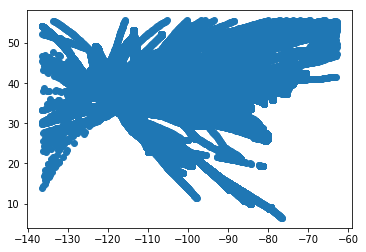

In [97]:
positions_geo_before.plot()

### After (April 7) points

In [98]:
positions_geo_after = gpd.GeoDataFrame(positions_geo_clipped[positions_geo_clipped['after'] == True])
# positions_geo_after = gpd.GeoDataFrame(positions_geo_clipped[positions_geo_clipped['after'] == True])

In [99]:
# positions_geo_after.to_file('/Users/mhustiles/data/data/flights/coronavirus\
# /positions_geo_after.geojson', driver='GeoJSON')

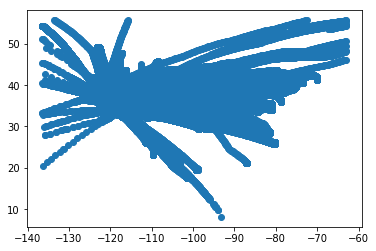

In [100]:
positions_geo_after.plot()

---

### Convert the points to lines

In [101]:
positions_geo_line = gpd.GeoDataFrame(positions_geo_clipped.groupby(['flight_id','schd_from','name','before'])['geometry']\
    .apply(lambda x: LineString(x.tolist())).reset_index())

### Lines for "before" flights

In [102]:
positions_geo_before_line = gpd.GeoDataFrame(positions_geo_before.groupby(['flight_id','schd_from','name','before'])['geometry']\
    .apply(lambda x: LineString(x.tolist())).reset_index())

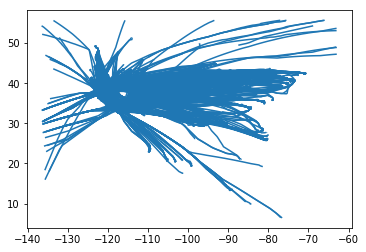

In [103]:
positions_geo_before_line.plot()

### Lines for "after" flights

In [104]:
positions_geo_after_line = gpd.GeoDataFrame(positions_geo_after.groupby(['flight_id','schd_from','name','before'])['geometry']\
    .apply(lambda x: LineString(x.tolist())).reset_index())

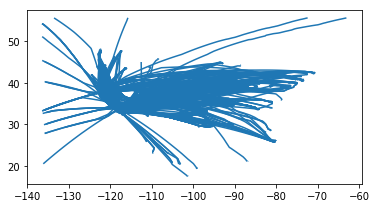

In [105]:
positions_geo_after_line.plot()

### Export all lines to geojson

In [106]:
positions_geo_line.to_file('/Users/mhustiles/data/data/flights/coronavirus\
/positions_geo_line.geojson', driver='GeoJSON')

### Output all before/after lines to mbtiles for Mapbox

In [107]:
!tippecanoe --generate-ids --force -Z4 -z10 -r1 -pk -pf -o \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_line_slim.mbtiles \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_line.geojson

For layer 0, using name "positions_geo_line"
4636 features, 4952256 bytes of geometry, 60824 bytes of separate metadata, 62223 bytes of string pool
  99.9%  10/248/378  


In [108]:
!tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_line.mbtiles \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_line.geojson

For layer 0, using name "positions_geo_after_line"
948 features, 1136041 bytes of geometry, 9589 bytes of separate metadata, 12976 bytes of string pool
  99.9%  12/771/1539   


In [109]:
!tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_line.mbtiles \
/Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_line.geojson

For layer 0, using name "positions_geo_before_line"
2703 features, 3244174 bytes of geometry, 27968 bytes of separate metadata, 36978 bytes of string pool
  99.9%  12/828/1541   


### Output airport-specific mbtiles for Mapbox

In [110]:
# for a in positions_geo_after_line['schd_from'].unique():
#     print(a)
    
#     !tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
#     /Users/mhustiles/data/data/flights/coronavirus/tiles/covid_'{a}'_after.mbtiles \
#     /Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_line_'{a}'.geojson

In [111]:
for a in positions_geo_before_line['schd_from'].unique():
    print(a)
    
    !tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
    /Users/mhustiles/data/data/flights/coronavirus/tiles/covid_'{a}'_before.mbtiles \
    /Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_line_'{a}'.geojson

LAX
For layer 0, using name "positions_geo_before_line_LAX"
814 features, 1021120 bytes of geometry, 9585 bytes of separate metadata, 10299 bytes of string pool
  99.9%  12/713/1652   
SNA
For layer 0, using name "positions_geo_before_line_SNA"
249 features, 273700 bytes of geometry, 3172 bytes of separate metadata, 4897 bytes of string pool
  99.9%  12/942/1650   
LGB
For layer 0, using name "positions_geo_before_line_LGB"
114 features, 171799 bytes of geometry, 1227 bytes of separate metadata, 2143 bytes of string pool
  99.9%  12/684/1624   
PSP
For layer 0, using name "positions_geo_before_line_PSP"
106 features, 123672 bytes of geometry, 1390 bytes of separate metadata, 2293 bytes of string pool
  99.9%  12/664/1596   
SFO
For layer 0, using name "positions_geo_before_line_SFO"
561 features, 728537 bytes of geometry, 6703 bytes of separate metadata, 7102 bytes of string pool
  99.9%  12/697/1635   
SAN
For layer 0, using name "positions_geo_before_line_SAN"
327 features, 366257 by

In [112]:
for a in positions_geo_after_line['schd_from'].unique():
    print(a)
    
    !tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
    /Users/mhustiles/data/data/flights/coronavirus/tiles/covid_'{a}'_after.mbtiles \
    /Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_line_'{a}'.geojson

BUR
For layer 0, using name "positions_geo_after_line_BUR"
43 features, 40355 bytes of geometry, 520 bytes of separate metadata, 759 bytes of string pool
  99.9%  12/889/1615   
SAN
For layer 0, using name "positions_geo_after_line_SAN"
121 features, 136651 bytes of geometry, 1445 bytes of separate metadata, 1708 bytes of string pool
  99.9%  12/935/1684   
SFO
For layer 0, using name "positions_geo_after_line_SFO"
169 features, 192504 bytes of geometry, 1994 bytes of separate metadata, 2293 bytes of string pool
  99.9%  12/735/1576   
LAX
For layer 0, using name "positions_geo_after_line_LAX"
298 features, 373782 bytes of geometry, 3513 bytes of separate metadata, 4040 bytes of string pool
  99.9%  12/1003/1695  
LGB
For layer 0, using name "positions_geo_after_line_LGB"
32 features, 54174 bytes of geometry, 348 bytes of separate metadata, 816 bytes of string pool
  99.9%  12/841/1571   
SMF
For layer 0, using name "positions_geo_after_line_SMF"
87 features, 99877 bytes of geometry, 1

---

### What's still flying at LAX?

In [113]:
lax_pos_after = positions_geo_after_line[positions_geo_after_line['schd_from'] == 'LAX']

In [114]:
lax_pos_before = positions_geo_before_line[positions_geo_before_line['schd_from'] == 'LAX']

In [115]:
lax_pos_after_names = lax_pos_after.groupby(['name']).agg('size').reset_index(name='flights')
lax_pos_before_names = lax_pos_before.groupby(['name']).agg('size').reset_index(name='flights')

In [116]:
lax_pos_before_names.sort_values(by='flights', ascending=False).head(5)

,name,flights
9,AMERICAN AIRLINES,173
21,DELTA AIR LINES,122
49,SKYWEST AIRLINES,108
50,SOUTHWEST AIRLINES,105
64,UNITED AIRLINES,83


In [117]:
lax_pos_after_names.sort_values(by='flights', ascending=False).head(5)

,name,flights
29,SOUTHWEST AIRLINES,46
4,AMERICAN AIRLINES,41
28,SKYWEST AIRLINES,31
12,DELTA AIR LINES,31
35,UNITED AIRLINES,28


In [118]:
before_after_lax_merge = pd.merge(lax_pos_before_names, lax_pos_after_names, on='name', how='inner')

In [119]:
before_after_lax_merge.rename(columns={"flights_x": "before", "flights_y": "after"}, inplace=True)

In [120]:
before_after_lax_merge.head()

,name,before,after
0,ALASKA AIRLINES,43,16
1,AMERICAN AIRLINES,173,41
2,ATLAS AIR,2,2
3,CARGO AIRCRAFT MANAGEMENT,2,4
4,DELTA AIR LINES,122,31


In [121]:
before_after_lax_merge['change'] = \
((before_after_lax_merge['after'] - before_after_lax_merge['before'])/\
 before_after_lax_merge['before']*100).round(2)

In [122]:
before_after_lax_merge.sort_values(by='before', ascending=False).to_csv('output/lax_before_after_webtable.csv', index=False)

In [123]:
before_after_lax_merge.sort_values(by='before', ascending=False).head(10)

,name,before,after,change
1,AMERICAN AIRLINES,173,41,-76.30
4,DELTA AIR LINES,122,31,-74.59
12,SKYWEST AIRLINES,108,31,-71.30
13,SOUTHWEST AIRLINES,105,46,-56.19
17,UNITED AIRLINES,83,28,-66.27
0,ALASKA AIRLINES,43,16,-62.79
7,JETBLUE AIRWAYS,25,7,-72.00
14,SPIRIT AIRLINES,22,19,-13.64
20,VIRGIN AMERICA,11,3,-72.73
6,HORIZON AIR INDUSTRIES,9,5,-44.44


In [124]:
lax_pos_before_names.to_csv('output/table_lax_pos_before_names.csv')
lax_pos_after_names.to_csv('output/table_lax_pos_after_names.csv')

### Top airlines before

In [125]:
lax_pos_before_names.flights.sum()

814

### Top airlines after

In [126]:
lax_pos_after_names.flights.sum()

298

### How much was the decline in total flights at LAX?

In [127]:
'{:,.2f}%'.format(((lax_pos_after_names.flights.sum() - \
   lax_pos_before_names.flights.sum())/lax_pos_before_names.flights.sum()*100))

'-63.39%'

---

### What's still flying at SFO?

In [128]:
sfo_pos_after = positions_geo_after_line[positions_geo_after_line['schd_from'] == 'SFO']

In [129]:
sfo_pos_before = positions_geo_before_line[positions_geo_before_line['schd_from'] == 'SFO']

In [130]:
sfo_pos_after_names = sfo_pos_after.groupby(['name']).agg('size').reset_index(name='flights')
sfo_pos_before_names = sfo_pos_before.groupby(['name']).agg('size').reset_index(name='flights')

In [131]:
sfo_pos_before_names.sort_values(by='flights', ascending=False).head(5)

,name,flights
39,UNITED AIRLINES,178
29,SKYWEST AIRLINES,120
30,SOUTHWEST AIRLINES,42
6,AMERICAN AIRLINES,42
7,DELTA AIR LINES,32


In [132]:
sfo_pos_after_names.sort_values(by='flights', ascending=False).head(5)

,name,flights
18,UNITED AIRLINES,52
14,SKYWEST AIRLINES,40
15,SOUTHWEST AIRLINES,18
1,AMERICAN AIRLINES,15
5,DELTA AIR LINES,10


In [133]:
before_after_sfo_merge = pd.merge(sfo_pos_before_names, sfo_pos_after_names, on='name', how='inner')

In [134]:
before_after_sfo_merge.rename(columns={"flights_x": "before", "flights_y": "after"}, inplace=True)

In [135]:
before_after_sfo_merge.head()

,name,before,after
0,ALASKA AIRLINES,31,9
1,AMERICAN AIRLINES,42,15
2,DELTA AIR LINES,32,10
3,HAWAIIAN AIRLINES,2,1
4,JET-I 2616 OWNER TRUST,2,1


In [136]:
before_after_sfo_merge['change'] = \
((before_after_sfo_merge['after'] - before_after_sfo_merge['before'])/\
 before_after_sfo_merge['before']*100).round(2)

In [137]:
before_after_sfo_merge.sort_values(by='before', ascending=False).to_csv('output/sfo_before_after_webtable.csv', index=False)

In [138]:
before_after_sfo_merge.sort_values(by='before', ascending=False).head(10)

,name,before,after,change
11,UNITED AIRLINES,178,52,-70.79
7,SKYWEST AIRLINES,120,40,-66.67
1,AMERICAN AIRLINES,42,15,-64.29
8,SOUTHWEST AIRLINES,42,18,-57.14
2,DELTA AIR LINES,32,10,-68.75
0,ALASKA AIRLINES,31,9,-70.97
13,VIRGIN AMERICA,22,3,-86.36
5,JETBLUE AIRWAYS,20,3,-85.00
12,UNITED EXPRESS,7,2,-71.43
10,UMB BANK NA TRUSTEE,5,2,-60.00


In [139]:
sfo_pos_before_names.to_csv('output/table_sfo_pos_before_names.csv')
sfo_pos_after_names.to_csv('output/table_sfo_pos_after_names.csv')

### Top airlines before

In [140]:
sfo_pos_before_names.flights.sum()

561

### Top airlines after

In [141]:
sfo_pos_after_names.flights.sum()

169

### How much was the decline in total flights at SFO?

In [142]:
'{:,.2f}%'.format(((sfo_pos_after_names.flights.sum() - \
   sfo_pos_before_names.flights.sum())/sfo_pos_before_names.flights.sum()*100))

'-69.88%'

---

### What's still flying at SNA?

In [143]:
sna_pos_after = positions_geo_after_line[positions_geo_after_line['schd_from'] == 'SNA']

In [144]:
sna_pos_before = positions_geo_before_line[positions_geo_before_line['schd_from'] == 'SNA']

In [145]:
sna_pos_after_names = sna_pos_after.groupby(['name']).agg('size').reset_index(name='flights')
sna_pos_before_names = sna_pos_before.groupby(['name']).agg('size').reset_index(name='flights')

In [146]:
sna_pos_before_names.sort_values(by='flights', ascending=False).head(10)

,name,flights
101,SOUTHWEST AIRLINES,41
108,UNITED AIRLINES,18
100,SKYWEST AIRLINES,16
18,AMERICAN AIRLINES,14
34,DELTA AIR LINES,14
15,ALASKA AIRLINES,6
35,DELUX PUBLIC CHARTER,6
72,NETJETS SALES,6
113,VIRGIN AMERICA,5
54,JG CAPITAL HOLDINGS,3


In [147]:
sna_pos_after_names.sort_values(by='flights', ascending=False).head(10)

,name,flights
16,SOUTHWEST AIRLINES,10
2,AMERICAN AIRLINES,4
18,UNITED AIRLINES,4
15,SKYWEST AIRLINES,4
9,HORIZON AIR INDUSTRIES,3
5,DELTA AIR LINES,2
0,ADVANCED CHARTER INDUSTRIES,1
14,PACIFIC FLIGHT AVIATION,1
22,WHEELS UP PARTNERS,1
21,VIRGIN AMERICA,1


In [148]:
before_after_sna_merge = pd.merge(sna_pos_before_names, sna_pos_after_names, on='name', how='inner')

In [149]:
before_after_sna_merge.rename(columns={"flights_x": "before", "flights_y": "after"}, inplace=True)

In [150]:
before_after_sna_merge.head(50)

,name,before,after
0,ADVANCED CHARTER INDUSTRIES,1,1
1,AMERICAN AIRLINES,14,4
2,CORBITT JAMES TODD,1,1
3,DELTA AIR LINES,14,2
4,DELUX PUBLIC CHARTER,6,1
5,HORIZON AIR INDUSTRIES,2,3
6,NETJETS SALES,6,1
7,PACIFIC FLIGHT AVIATION,3,1
8,SKYWEST AIRLINES,16,4
9,SOUTHWEST AIRLINES,41,10


In [151]:
before_after_sna_merge['change'] = \
((before_after_sna_merge['after'] - before_after_sna_merge['before'])/\
 before_after_sna_merge['before']*100).round(2)

In [152]:
before_after_sna_merge.sort_values(by='before', ascending=False).to_csv('output/sna_before_after_webtable.csv', index=False)

In [153]:
before_after_sna_merge.sort_values(by='before', ascending=False).head(10)

,name,before,after,change
9,SOUTHWEST AIRLINES,41,10,-75.61
10,UNITED AIRLINES,18,4,-77.78
8,SKYWEST AIRLINES,16,4,-75.00
1,AMERICAN AIRLINES,14,4,-71.43
3,DELTA AIR LINES,14,2,-85.71
4,DELUX PUBLIC CHARTER,6,1,-83.33
6,NETJETS SALES,6,1,-83.33
12,VIRGIN AMERICA,5,1,-80.00
7,PACIFIC FLIGHT AVIATION,3,1,-66.67
5,HORIZON AIR INDUSTRIES,2,3,50.00


In [154]:
sna_pos_before_names.to_csv('output/table_sna_pos_before_names.csv')
sna_pos_after_names.to_csv('output/table_sna_pos_after_names.csv')

### Top airlines before

In [155]:
sna_pos_before_names.flights.sum()

249

### Top airlines after

In [156]:
sna_pos_after_names.flights.sum()

45

### How much was the decline in total flights at SFO?

In [157]:
'{:,.2f}%'.format(((sna_pos_after_names.flights.sum() - \
   sna_pos_before_names.flights.sum())/sna_pos_before_names.flights.sum()*100))

'-81.93%'

---

## Flights by airline

### American Airlines before

In [158]:
aa_before_line_lax = positions_geo_before_line[(positions_geo_before_line['name'] == 'AMERICAN AIRLINES')&\
                                              (positions_geo_before_line['schd_from'] == 'LAX')]

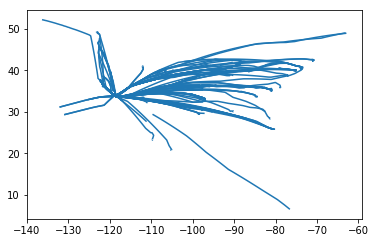

In [159]:
aa_before_line_lax.plot()

### American Airlines after

In [160]:
aa_after_line_lax = positions_geo_after_line[(positions_geo_after_line['name'] == 'AMERICAN AIRLINES')&\
                                              (positions_geo_after_line['schd_from'] == 'LAX')]

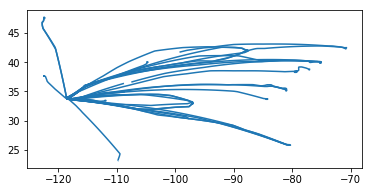

In [161]:
aa_after_line_lax.plot()

### Export to geojson and mbtiles

In [162]:
# aa_before_line_lax.to_file('/Users/mhustiles/data/data/flights/coronavirus/aa_before_line_lax.geojson', \
#                            driver='GeoJSON')
# aa_after_line_lax.to_file('/Users/mhustiles/data/data/flights/coronavirus/aa_after_line_lax.geojson', \
#                            driver='GeoJSON')

In [163]:
# !tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
# /Users/mhustiles/data/data/flights/coronavirus/aa_before_line_lax.mbtiles \
# /Users/mhustiles/data/data/flights/coronavirus/aa_before_line_lax.geojson

In [164]:
# !tippecanoe --generate-ids --force -Z3 -z12 -r1 -pk -pf -o \
# /Users/mhustiles/data/data/flights/coronavirus/aa_after_line_lax.mbtiles \
# /Users/mhustiles/data/data/flights/coronavirus/aa_after_line_lax.geojson

---

### Cut 'before' GeoJSON files for each of our airports before COVID-19

In [165]:
for airport in positions_geo_before.schd_from.unique():
    positions_geo_before[positions_geo_before['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_before_{}.geojson'.format(airport), driver='GeoJSON')

In [166]:
for airport in positions_geo_before_line.schd_from.unique():
    positions_geo_before_line[positions_geo_before_line['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_before_line_{}.geojson'.format(airport), driver='GeoJSON')

### Cut 'after' GeoJSON files for each of our airports after COVID-19

In [167]:
for airport in positions_geo_after.schd_from.unique():
    positions_geo_after[positions_geo_after['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_after_{}.geojson'.format(airport), driver='GeoJSON')

In [168]:
for airport in positions_geo_after_line.schd_from.unique():
    positions_geo_after_line[positions_geo_after_line['schd_from'] == '{}'.format(airport)]\
    .to_file('/Users/mhustiles/data/data/flights/coronavirus/\
positions_geo_after_line_{}.geojson'.format(airport), driver='GeoJSON')

---

### Grid (CA 1 mile)

In [169]:
# grid = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/socal-halfmile.geojson')

In [170]:
# grid.crs = {'init': 'epsg:4326'}
# grid.to_crs({'init': 'epsg:4326'})

In [171]:
# grid.plot()

In [172]:
# df_la = pd.DataFrame()

# for n in la_choppers:
#     c = n['n_number']
#     choppers = positions_geo[positions_geo['reg'] == c]
#     choppers.crs = "epsg:4326"
#     dfsjoin = gpd.sjoin(hexbins,choppers)
#     dfpivot = pd.pivot_table(dfsjoin,index='id',columns='n_number',aggfunc={'n_number':len})
#     dfpivot.columns = dfpivot.columns.droplevel()
#     dfpolynew = hexbins.merge(dfpivot, how='left',on='id')
#     dfpolynew.to_file('/Users/mhustiles/data/data/helicopters/' + c + 'hex.geojson', driver='GeoJSON')

In [173]:
# lax_before = gpd.read_file('/Users/mhustiles/data/data/flights/coronavirus/positions_geo_before_LAX.geojson')
# lax_after = gpd.read_file('/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_LAX.geojson')

In [174]:
# positions_geo_before_flying = positions_geo_before[positions_geo_before['speed'] > 10 ]
# positions_geo_after_flying = positions_geo_after[positions_geo_after['speed'] > 10 ]

In [175]:
# positions_geo_before_flying.crs = {'init': 'epsg:4326'}
# positions_geo_before_flying.to_crs({'init': 'epsg:4326'})
# positions_geo_after_flying.crs = {'init': 'epsg:4326'}
# positions_geo_after_flying.to_crs({'init': 'epsg:4326'})

In [176]:
# dfsjoin = gpd.sjoin(positions_geo_after_flying, grid)

In [177]:
# dfsjoingroup = dfsjoin.groupby(['id']).agg('size').reset_index(name='pings')

In [178]:
# dfpolynew = grid.merge(dfsjoingroup, how='left',on='id')

In [179]:
# dfpolynew.to_file('/Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_grid.geojson', driver='GeoJSON')

In [180]:
# # !tippecanoe --generate-ids --force -r1 -pk -pf -o \
#     /Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_grid.mbtiles \
#     /Users/mhustiles/data/data/flights/coronavirus/positions_geo_after_grid.geojson

---

## Mapbox static API

### CA flights map

In [181]:
#before code = ck8meit0i1k2d1inzp53epjgf
'https://api.mapbox.com/styles/v1/latimes/ck93697cw1al01ir1hdlfgpsr/static/-119.6506,35.8239,6.5,0/1280x812@2x?access_token=pk.eyJ1IjoibGF0aW1lcyIsImEiOiJjajhvcXRraGUwNnlwMzNyczR3cTBsaWh1In0.0cPKLwe2A0ET4P5CtWSiLQ'

'https://api.mapbox.com/styles/v1/latimes/ck93697cw1al01ir1hdlfgpsr/static/-119.6506,35.8239,6.5,0/1280x812@2x?access_token=pk.eyJ1IjoibGF0aW1lcyIsImEiOiJjajhvcXRraGUwNnlwMzNyczR3cTBsaWh1In0.0cPKLwe2A0ET4P5CtWSiLQ'

In [182]:
#after code: ck93697cw1al01ir1hdlfgpsr
'https://api.mapbox.com/styles/v1/\
    latimes/ck93697cw1al01ir1hdlfgpsr/static/-119.6506,35.8239,6.5,0/1280x812@2x?access_token=\
    pk.eyJ1IjoibGF0aW1lcyIsImEiOiJjajhvcXRraGUwNnlwMzNyczR3cTBsaWh1In0.0cPKLwe2A0ET4P5CtWSiLQ'

'https://api.mapbox.com/styles/v1/    latimes/ck93697cw1al01ir1hdlfgpsr/static/-119.6506,35.8239,6.5,0/1280x812@2x?access_token=    pk.eyJ1IjoibGF0aW1lcyIsImEiOiJjajhvcXRraGUwNnlwMzNyczR3cTBsaWh1In0.0cPKLwe2A0ET4P5CtWSiLQ'

In [183]:
https://api.mapbox.com/styles/v1/latimes/ck9aky6tk0nbc1iodbmrpsq2s/static/-117.600344,34.054807,10,0/1280x812@2x?access_token=pk.eyJ1IjoibGF0aW1lcyIsImEiOiJjajhvcXRraGUwNnlwMzNyczR3cTBsaWh1In0.0cPKLwe2A0ET4P5CtWSiLQ

SyntaxError: invalid syntax (<ipython-input-183-d373665c6edd>, line 1)